# A non-neural baseline

In this kernel I match the baseline introduced [here](https://arxiv.org/abs/1810.05201). Unlike in my previous kernel, I use spaCy for parsing, whose data structures are very easy to work with.

Besides the parsing step, the model is completely non-neural and doesn't rely on word embeddings. As expected, it does not come close to the performance of modern deep transfer learning approaches. However, with some tweaking I was able to reach 0.57 log loss.

### Model architecture

1. Build a global list of candidates using an entity recognizer and make sure both provided candidates are in there.
2. Disqualify some candidates using well-understood grammatical constraints on coreference.
3. Divide remaining candidates into 3 groups A, B, N based on what entity they are likely an instance of.
4. For each group, compute some features based on testing its instances on metrics like prominence, locality, etc.
5. Feed those features into a standard ensemble classifier.

### Two take-aways:

1. A *major* problem is the cascading effect of misparses. Obviously this is an inherent danger of using intermediate representations like dependency parses, and not directly training on the task at hand.
2. A zillion manual tweaks are possible, and some have elegant spaCy implementations, but the return given the effort is rather slim.
3. The thing the model did worst on is detecting cases where neither suggested candidate was correct. I wonder if that is specific to the approach here or if everyone is finding that to some extent.



In [1]:
import spacy
import pandas as pd
import numpy as np
nlp = spacy.load('en_core_web_lg')

# Load the GAP data

data = pd.concat([pd.read_csv('https://github.com/google-research-datasets/gap-coreference/blob/master/gap-development.tsv?raw=true', sep='\t'),
                  pd.read_csv('https://github.com/google-research-datasets/gap-coreference/blob/master/gap-validation.tsv?raw=true', sep='\t'),
                  pd.read_csv('https://github.com/google-research-datasets/gap-coreference/blob/master/gap-test.tsv?raw=true', sep='\t')
                 ], ignore_index = True)

In [2]:
# Two useful syntactic relations

def domain(t):
    while not t._.subj and not t._.poss and\
            not (t.dep_ == 'xcomp' and t.head._.obj) and\
            t != t.head:
        t = t.head
    return t

def ccom(t):
    return [t2 for t2 in t.head._.d]

# spacy extensions:
#   doc._.to(offset) => t at text char offset
#   t._.c => t's children (list)                     #   t._.d => t's descendents (list)
#   t._.subj => t's subject else False               #   t._.obj => t's object else False
#   t._.domain => t's syntactic domain               #   t._.ccom => t's c-command domain

spacy.tokens.doc.Doc.set_extension(
    'to', method=lambda doc, offset: [t for t in doc if t.idx == offset][0], force=True)
spacy.tokens.token.Token.set_extension(
    'c', getter=lambda t: [c for c in t.children], force=True)
spacy.tokens.token.Token.set_extension(
    'd', getter=lambda t: [c for c in t.sent if t in list(c.ancestors)], force=True)
spacy.tokens.token.Token.set_extension(
    'subj', getter=lambda t: ([c for c in t._.c if c.dep_.startswith('nsubj')] + [False])[0], force=True)
spacy.tokens.token.Token.set_extension(
    'obj', getter=lambda t: ([c for c in t._.c if c.dep_.startswith('dobj')] + [False])[0], force=True)
spacy.tokens.token.Token.set_extension(
    'poss', getter=lambda t: ([c for c in t._.c if c.dep_.startswith('poss')] + [False])[0], force=True)
spacy.tokens.token.Token.set_extension(
    'span', method=lambda t, t2: t.doc[t.i:t2.i] if t.i < t2.i else t.doc[t2.i:t.i], force=True)
spacy.tokens.token.Token.set_extension('domain', getter=domain, force=True)
spacy.tokens.token.Token.set_extension('ccom', getter=ccom, force=True)

In [3]:
# Disqualification functions

# Prune candidate list given a disqualifying condition (a set of tokens)
def applyDisq(condition, candidates, candidate_dict, debug = False):
    badnames = sum([nameset(c, candidate_dict) for c in candidates if c in condition[0]], [])
    badcands = [c for c in candidates if c.text in badnames]
    if debug and len(badcands) > 0: print('Disqualified:', badcands, '<', condition[1])
    return [c for c in candidates if c not in badcands]

# Apply a list of disqualifying conditions
def applyDisqs(conditions, candidates, candidate_dict, debug = False):
    for condition in conditions:
        if len(candidates) < 1: return candidates
        candidates = applyDisq(condition, candidates, candidate_dict, debug)
    return candidates

# Pass the list of disqualifying conditions for possessive pronouns (his, her)
def disqGen(t, candidates, candidate_dict, debug = False):
    conds = [(t._.ccom,
             "disqualify candidates c-commanded by genpn; e.g. e.g. *Julia read his_i book about John_i's life."),
             ([t2 for t2 in candidates if t in t2._.ccom and t2.head.dep_ == 'appos'],
             "disqualify candidates modified by an appositive with genpn; e.g. *I wanted to see John_i, his_i father.")
            ]
    return applyDisqs(conds, candidates, candidate_dict, debug)

# Pass the list of list of disqualifying conditions for other pronouns
def disqOthers(t, candidates, candidate_dict, debug = False):
    conds = [([t2 for t2 in t._.ccom if t2.i > t.i],
             "disqualify candidates c-commanded by pn, unless they were preposed;\
             e.g. *He_i cried before John_i laughed. vs. Before John_i laughed, he_i cried."),
             ([t2 for t2 in candidates if t in t2._.ccom and t2._.domain == t._.domain
              and not (t.head.text == 'with' and t.head.head.lemma_ == 'take')],
             "disqualify candidates that c-command pn, unless in different domain;\
             e.g. Mary said that *John_i hit him_i. vs. John_i said that Mary hit him_i;\
             random hard-coded exception: `take with'"),
             ([t2 for t2 in candidates if t2._.domain.dep_ == 'xcomp' and t2._.domain.head._.obj and t2 == t2._.domain.head._.obj],
             "for xcomps with subjects parsed as upstairs dobj, disallow coref with that dobj;\
             e.g. *Mary wanted John_i to forgive him_i.")
            ]
    return applyDisqs(conds, candidates, candidate_dict, debug)

# Decide whether possessive or not and call appropriate function
def disq(t, candidates, candidate_dict, debug = False):
    func = disqGen if t.dep_ == 'poss' else disqOthers
    candidates = func(t, candidates, candidate_dict, debug)
    return candidates

In [4]:
# Name functions

# Find word of interest at provided offset; sometimes parsed words don't align with provided data, so need to look back
def find_head(w, wo, doc):
    t = False; backtrack = 0
    while not t:
        try:
            t = doc._.to(wo)
        except IndexError:
            wo -= 1; backtrack += 1
    while t.dep_ == 'compound' and t.head.idx >= wo and t.head.idx < len(w) + wo + backtrack: t = t.head
    return t

# Returns subsequences of a name
def subnames(name):
    if type(name) != str: name = candidate_dict[name]
    parts = name.split(' ')
    subnames_ = []
    for i in range(len(parts)): 
        for j in range(i + 1, len(parts) + 1): 
            sub = ' '.join(parts[i:j])
            if len(sub) > 2: subnames_.append(sub)
    return subnames_

# Returns subsequences of a name unless potentially ambiguous (if another candidate picks out same subsequence)
def nameset(name, candidate_dict):
    if type(name) != str: name = candidate_dict[name]
    subnames_ = [sn for sn in subnames(name)]
    return [c for c in subnames_ if c not in sum([subnames(c) for c in candidate_dict.values() 
                                                  if c not in subnames_ and name not in subnames(c)], [])]

# Given the original candidate dict and the final candidate list, returns new dict grouping putative candidate instances under a single key
def candInstances(candidates, candidate_dict):
    candidates_by_name = {}
    for c in sorted(candidates, key = lambda c: len(candidate_dict[c]), reverse = True):
        name = candidate_dict[c]
        for name2 in candidates_by_name.keys():
            if name in nameset(name2, candidate_dict): name = name2; break
        candidates_by_name[name] = candidates_by_name.get(name, []) + [c]
    return candidates_by_name

import gender_guesser.detector as gender # oops
gd = gender.Detector()

# Needed to prune candidate dict-- removes non-provided candidates that don't match in most common gender with pn
def filterGender(candidates_by_name, a, b, pn):
    badnames = []
    gender = 'female' if pn in ['She', 'she', 'her', 'Her'] else 'male'
    for name in candidates_by_name.keys():
        if a in subnames(name) or b in subnames(name): continue
        genderii = gd.get_gender(name.split(' ')[0])
        if gender == 'male' and genderii == 'female': badnames += [name]; continue
        if gender == 'female' and genderii == 'male': badnames += [name]; continue
    for name in badnames: candidates_by_name.pop(name)
    return candidates_by_name

In [5]:
# Metrics

from urllib.parse import unquote
import re

# Authors' metric 1: Does the Wikipedia url contain the candidate's name?
def urlMatch(a, b, url, candidate_dict):
    url = re.sub('[^\x00-\x7F]', '*', unquote(url.split('/')[-1])).replace('_', ' ').lower()
    return {'a_url': (sorted([len(n.split(' ')) for n in nameset(a.lower(), candidate_dict) if n in nameset(url, candidate_dict)], reverse = True) + [0])[0],
            'b_url': (sorted([len(n.split(' ')) for n in nameset(b.lower(), candidate_dict) if n in nameset(url, candidate_dict)], reverse = True) + [0])[0]}

# Authors' metric 2: When pn is subject or object, does the candidate match?
def parallel(t1, t2):
    if t1.dep_.startswith('nsubj'): return t2.dep_.startswith('nsubj')
    if t1.dep_.startswith('dobj'): return t2.dep_.startswith('dobj')
    if t1.dep_.startswith('dative'): return t2.dep_.startswith('dative')
    return False

# Depth from a node to a parent node
def depthTo(t1, t2):
    depth = 0
    while t1 != t2 and t1 != t1.head:
        t1 = t1.head
        depth += 1
    return depth

# Syntactic distance within a single tree
def nodeDist(t1, t2):
    if t1 == t2: return 0
    if t2 in t1._.d: return depthTo(t2, t1)
    if t1 in t2._.d: return depthTo(t1, t2)
    t = t1
    while t1 not in t._.d or t2 not in t._.d and t != t.head: t = t.head
    return depthTo(t1, t) + depthTo(t2, t)

# Authors' metric 3: Syntactic distance (within or across trees)
def synDist(t, pn, doc, debug = False):
    doc_sents = list(doc.sents)
    sspan = doc_sents.index(pn.sent) - doc_sents.index(t.sent)
    if sspan == 0: # same sentence
        dist = nodeDist(t, pn)
    else: # different sentence
        dist = nodeDist(pn, doc_sents[doc_sents.index(pn.sent)].root) + nodeDist(t, doc_sents[doc_sents.index(t.sent)].root) # dist from two roots
    if debug: 
        print('pn dist:', nodeDist(pn, doc_sents[doc_sents.index(pn.sent)].root), '; t dist:',
              nodeDist(t, doc_sents[doc_sents.index(t.sent)].root), '; span:', sspan)
    sspan = abs(sspan) * 1 if sspan >= 0 else abs(sspan) * 1.3 # less local if not preceding
    return dist + sspan# * 0.7

# Character distance
def charDist(t1, t2):
    if t2.idx > t1.idx:
        return t2.idx - t1.idx + len(t1.text)
    else:
        return (t1.idx - t2.idx + len(t2.text)) * 1.3

# Theta prominence: assign a 0.1 to 1 score based on dep role of candidate -- strong feature
def thetaProminence(t, mult = 1, debug = False):
    while t.dep_ == 'compound': t = t.head
    if debug: print('t dep_:', t.dep_)
    if t.dep_ == 'pobj': mult = 1.3 if t.head.i < t.head.head.i else 1
    if t._.domain.dep_ == 'advcl': mult = 1.3 if t.head.i < t._.domain.head.i else 1
    if t.dep_.startswith('nsubj'): score = 1
    elif t.dep_.startswith('dobj'): score = 0.8
    elif t.dep_.startswith('dative'): score = 0.6
    elif t.dep_.startswith('pobj'): score = 0.4
    elif t.dep_.startswith('poss'): score = 0.3
    else: score = 0.1
    if debug: print('mult:', mult, '; score:', score)
    return min(1, score * mult)

# Computes these metrics for each candidate, and returns, for each group of instances (A instances, B instances,\
# other instances), either the sum, or the highest difference from the mean
def score(label, candidates_by_name, a_cand, b_cand, func, minsc = None, method = 'sum'):
    if method == 'sum':
        scores = {name: sum([func(t) for t in tokens]) for name, tokens in candidates_by_name.items()}
    elif method == 'meandiff':
        mean = np.mean(sum([[func(t) for t in tokens] for tokens in candidates_by_name.values()], []))
        scores = {name: mean - min([func(t) for t in tokens]) for name, tokens in candidates_by_name.items()}
    sca = scores[a_cand] if a_cand else minsc
    scb = scores[b_cand] if b_cand else minsc
    screst = [v for n, v in scores.items() if n != a_cand and n != b_cand]
    if method == 'sum':
        screst = sum(screst) if len(screst) > 0 else minsc
    elif method == 'meandiff':
        screst = max(screst) if len(screst) > 0 else minsc
    return {'a_' + label: sca, 'b_' + label: scb, 'n_' + label: screst}

In [6]:
from tqdm import tqdm_notebook as tqdm

# Load a rowfull of data
def load_row(data, i):
    return tuple(data.iloc[i])

# Row by row, populate features
def annotateSet(data, minsc = None, debug = False):
    
    annotated_data = pd.DataFrame() # init placeholder df
    row_batch = []

    for i in tqdm(range(annotated_data.shape[0], data.shape[0])):
        id, text, pn, pno, a, ao, ag, b, bo, bg, url = load_row(data, i)        
        doc = nlp(text) # parse text into doc
        pnt, at, bt = (doc._.to(pno), find_head(a, ao, doc), find_head(b, bo, doc)) # get the tokens that correspond to offsets
        candidate_dict = {e.root: re.sub('\'s$', '', e.text) for e in [e for e in doc.ents if e.root.ent_type_ == 'PERSON']} # first get every PERSON ent as candidate
        candidate_dict.update({c.root: re.sub('\'s$', '', c.text) for c in doc.noun_chunks if c.root.pos_ == 'PROPN' and c.text in sum([subnames(n) for n in candidate_dict.values()], []) and
                               c.root not in candidate_dict.keys()}) # get some missed ones by looking at noun chunks with PROPN roots whose text match part of a candidate but are not already in list
        candidate_dict.update({t: w for t, w in [(at, a), (bt, b)]}) # add provided cands, overwriting in the process

        candidates = disq(pnt, list(candidate_dict.keys()), candidate_dict, debug = False)
        candidates_by_name = candInstances(candidates, candidate_dict)
        candidates_by_name = filterGender(candidates_by_name, a, b, pn)
        a_cand = ([name for name, tokens in candidates_by_name.items() if at in tokens] + [False])[0]
        b_cand = ([name for name, tokens in candidates_by_name.items() if bt in tokens] + [False])[0]
    
        # init row dict
        features = {'id': id, 'label': 0 if ag else 1 if bg else 2}
        # eliminated or not
        features.update({'a_out': 0 if a_cand else 1, 'b_out': 0 if b_cand else 1})
        # url match or not
        features.update(urlMatch(a, b, url, candidate_dict))
        # c-command or not
        features.update({'a_cc': 1 if a_cand and pnt in at._.ccom else 0, 'b_cc': 1 if b_cand and pnt in bt._.ccom else 0})
        # parallelism score
        features.update(score('par', candidates_by_name, a_cand, b_cand, lambda t: parallel(t, pnt), minsc = minsc))
        # theta prominence score
        features.update(score('th', candidates_by_name, a_cand, b_cand, thetaProminence, minsc = minsc))
        # syntactic distance score
        features.update(score('loc', candidates_by_name, a_cand, b_cand, lambda t: synDist(t, pnt, doc), method='meandiff', minsc = minsc))
        # number of candidates left
        features.update({'n_cands': len(candidates_by_name)})
        # char dist
        features.update(score('cloc', candidates_by_name, a_cand, b_cand, lambda t: charDist(t, pnt), method='meandiff', minsc = minsc))

        if debug: print(id, '>', 'a:', 1 if ag else 0, 'b:', 1 if bg else 0, features)
        row_batch += [features]

    # add rows to placeholder df
    if annotated_data.shape[0] != data.shape[0]: annotated_data = annotated_data.append(row_batch, ignore_index = True)
    
    return annotated_data

## Running the annotation script and vizualizing errors

In [8]:
annotated_data = annotateSet(data)

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
# Readable rows

from textwrap import TextWrapper
wrapper = TextWrapper(width=75)

def style(w, wstyle):
    if wstyle == None: return '{}{}{}'.format('\033[1m', w, '\033[0m') # bold
    elif wstyle == True: return '{}{}{}'.format('\033[92m', w, '\033[0m') # green
    elif wstyle == False: return '{}{}{}'.format('\033[91m', w, '\033[0m') # red

def readable_rows(data, range):
    rows = []
    for i in range:
        wois = sorted([(data.iloc[i]['Pronoun'], data.iloc[i]['Pronoun-offset'], None),\
                   (data.iloc[i]['A'], data.iloc[i]['A-offset'], data.iloc[i]['A-coref']),\
                   (data.iloc[i]['B'], data.iloc[i]['B-offset'], data.iloc[i]['B-coref'])],\
                   key = lambda x: x[1]) # sort by offset
        text = ''; ftext = data.iloc[i]['Text']; coffset = 0
        for w, woffset, wstyle in wois:
            text += ftext[coffset:woffset] + style(w, wstyle)
            coffset += len(ftext[coffset:woffset]) + len(w)
        text += ftext[coffset:]
        rows += [(str(i), data.iloc[i]['ID'], 'A' if data.iloc[i]['A-coref'] else 'B' if data.iloc[i]['B-coref'] else 'N', text)]
    return rows

def print_readable_rows(data, range):
    for index, id, target, text in readable_rows(data, range):
        text = '\n\t'.join(wrapper.wrap(text = text))
        print('{} ({}): {}>\n\t{}\n'.format(id, index, target, text))
        
def print_tokens(doc):
    for i in range(0, len(doc), 3):
        for t in doc[i:i+3]:
            print("{}[{}] >{}> {}".format(t.text, t.pos_, t.dep_, t.head.text), end = ' | ')
        print('')

In [10]:
misdisqs_a = annotated_data.loc[(annotated_data['a_out'] == 1) & (annotated_data['label'] == 0)]
misdisqs_b = annotated_data.loc[(annotated_data['b_out'] == 1) & (annotated_data['label'] == 1)]

print('As wrongly disqualified:', misdisqs_a.shape[0], ', Bs wrongly disqualified:', misdisqs_b.shape[0], '\n')

for i in misdisqs_a.index[:1]: # the first
    print_readable_rows(data, [i])
    id, text, pn, pno, a, ao, ag, b, bo, bg, url = load_row(data,i)
    doc = nlp(text); print_tokens(doc)
    print('')

As wrongly disqualified: 52 , Bs wrongly disqualified: 89 

development-117 (116): A>
	Although he has an ugly appearance, he is very fit, agile and nimble. He
	goes to Jizhou (**) and steals for a living. He is nicknamed ``Flea on a
	Drum'' for his excellent thieving skills. Shi Qian runs into some
	trouble in Jizhou (present-day Ji County, Tianjin) and Yang Xiong
	helps him.

Although[ADP] >mark> has | he[PRON] >nsubj> has | has[VERB] >advcl> is | 
an[DET] >det> appearance | ugly[ADJ] >amod> appearance | appearance[NOUN] >dobj> has | 
,[PUNCT] >punct> is | he[PRON] >nsubj> is | is[VERB] >ROOT> is | 
very[ADV] >advmod> fit | fit[ADJ] >acomp> is | ,[PUNCT] >punct> fit | 
agile[ADJ] >conj> fit | and[CCONJ] >cc> agile | nimble[ADJ] >conj> agile | 
.[PUNCT] >punct> is | He[PRON] >nsubj> goes | goes[VERB] >ROOT> goes | 
to[ADP] >prep> goes | Jizhou[PROPN] >pobj> to | ([PUNCT] >punct> Jizhou | 
*[PUNCT] >subtok> * | *[PUNCT] >punct> ) | )[PUNCT] >punct> and | 
and[CCONJ] >cc> steals | steal

This is a misparse as \[Yang Xiong helps him\] is not parsed as one unit. If it had been, the disqualification algorithm would have spared 'Shi Quan.'

## The ML part

In [11]:
train = annotated_data.loc[(annotated_data['id'].str.contains('test'))] # swap later
valid = annotated_data.loc[(annotated_data['id'].str.contains('validation'))]
train_valid = pd.concat([train, valid])
test = annotated_data.loc[(annotated_data['id'].str.contains('development'))] # swap later

answer_columns = ['label']
excl = ['id']
excl += ['a_out', 'b_out']
feature_columns = [col for col in annotated_data.columns if col not in answer_columns and col not in excl]

X_train = train[feature_columns]
y_train = np.array(train[answer_columns]).ravel().astype(int)
X_valid = valid[feature_columns]
y_valid = np.array(valid[answer_columns]).ravel().astype(int)
X_train_valid = train_valid[feature_columns]
y_train_valid = np.array(train_valid[answer_columns]).ravel().astype(int)
X_test = test[feature_columns]
y_test = np.array(test[answer_columns]).ravel().astype(int)

random_state = 56

X_train.corr()

,a_cc,a_cloc,a_loc,a_par,a_th,a_url,b_cc,b_cloc,b_loc,b_par,b_th,b_url,n_cands,n_cloc,n_loc,n_par,n_th
a_cc,1.000000,0.129513,0.279522,0.016539,0.306212,-0.015789,0.190053,-0.025806,0.145530,-0.024440,0.036126,-0.048767,0.029104,-0.035790,-0.185571,-0.033703,0.005924
a_cloc,0.129513,1.000000,0.344558,0.025639,0.268492,-0.070828,0.071516,0.470447,0.301911,0.112262,0.288477,0.064730,0.372927,0.038776,0.063138,0.091558,0.313229
a_loc,0.279522,0.344558,1.000000,0.200642,0.398884,0.179765,-0.228707,0.167109,-0.132380,-0.059551,-0.088364,-0.165139,0.251161,0.100296,-0.111462,0.020737,0.127957
a_par,0.016539,0.025639,0.200642,1.000000,0.467209,0.246315,-0.140608,0.094298,-0.124928,0.175059,-0.035879,-0.139406,-0.090629,-0.013291,-0.096330,0.285919,-0.038360
a_th,0.306212,0.268492,0.398884,0.467209,1.000000,0.281237,-0.039612,0.153904,-0.027833,-0.015267,0.026301,-0.169447,-0.072238,0.033534,-0.130164,0.035546,-0.019363
a_url,-0.015789,-0.070828,0.179765,0.246315,0.281237,1.000000,-0.186662,-0.031127,-0.232622,-0.133749,-0.252860,-0.244785,-0.052429,0.011474,-0.052382,-0.065581,-0.141240
b_cc,0.190053,0.071516,-0.228707,-0.140608,-0.039612,-0.186662,1.000000,0.114437,0.531280,0.052597,0.362007,0.198029,0.010186,-0.082956,-0.175097,-0.060359,-0.020834
b_cloc,-0.025806,0.470447,0.167109,0.094298,0.153904,-0.031127,0.114437,1.000000,0.364730,0.088815,0.240529,0.051320,0.325651,-0.047297,0.018933,0.135202,0.231413
b_loc,0.145530,0.301911,-0.132380,-0.124928,-0.027833,-0.232622,0.531280,0.364730,1.000000,0.142093,0.408190,0.207202,0.209847,-0.000267,-0.200052,-0.011013,0.073457
b_par,-0.024440,0.112262,-0.059551,0.175059,-0.015267,-0.133749,0.052597,0.088815,0.142093,1.000000,0.447412,0.186800,-0.063783,-0.016693,-0.075671,0.180508,-0.025183


Accuracy: 0.7445 
Recall: [0.79061785 0.76864865 0.43283582] 
Precision: [0.74702703 0.77031419 0.57236842] 
F1: [0.76820456 0.76948052 0.49291785] 
Log-loss: 0.6026347006466239
     a_pred    b_pred    n_pred  a  b  n
0  0.397109  0.201932  0.400959  1  0  0
1  0.846954  0.114793  0.038253  1  0  0
2  0.058670  0.926630  0.014700  0  1  0
3  0.412462  0.416224  0.171313  0  1  0
4  0.103577  0.731851  0.164572  0  1  0


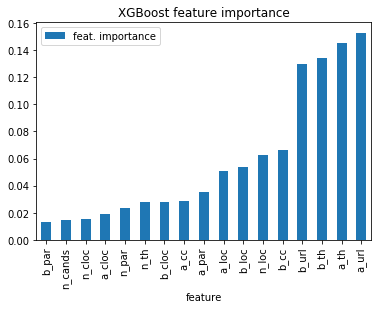

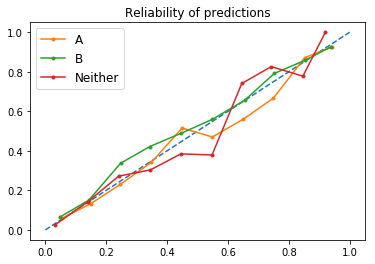

In [12]:
# Train a classifier on it

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss

clf = XGBClassifier(random_state=random_state)
clf.fit(X_train_valid.values, y_train_valid)
y_pred = clf.predict(X_test.values)
y_probs = clf.predict_proba(X_test.values)
print('Accuracy:', accuracy_score(y_test, y_pred),
      '\nRecall:', recall_score(y_test, y_pred, average=None),
      '\nPrecision:', precision_score(y_test, y_pred, average=None),
      '\nF1:', f1_score(y_test, y_pred, average=None),
      '\nLog-loss:', log_loss(y_test, y_probs))

y_test_prime = np.array([(y_test == 0), (y_test == 1), (y_test == 2)]).transpose().astype(int)

# first few predictions
print(pd.DataFrame({'a_pred': y_probs[:,0], 'b_pred': y_probs[:,1], 'n_pred': y_probs[:,2],
                    'a': y_test_prime[:,0], 'b': y_test_prime[:,1], 'n': y_test_prime[:,2]}).head())

fscores = pd.DataFrame({'feature': feature_columns, 'feat. importance': clf.feature_importances_})
fscores.sort_values(by='feat. importance').plot.bar(x='feature')
plt.title('XGBoost feature importance')
plt.show()

plt.title('Reliability of predictions')
plt.plot([0, 1], [0, 1], linestyle='--') # diagonal for reference
fop, mpv = calibration_curve(y_test_prime[:,0], y_probs[:,0], n_bins=10) # As
plt.plot(mpv, fop, marker='.', label='A')
fop, mpv = calibration_curve(y_test_prime[:,1], y_probs[:,1], n_bins=10) # Bs
plt.plot(mpv, fop, marker='.', label='B')
fop, mpv = calibration_curve(y_test_prime[:,2], y_probs[:,2], n_bins=10) # Ns
plt.plot(mpv, fop, marker='.', label='Neither')
plt.legend(loc='upper left', prop={'size': 12})
plt.show()

In [13]:
# Bayesian Optimization

from bayes_opt import BayesianOptimization

def xgb_evaluate(max_depth, n_estimators, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree):
    evalmodel = XGBClassifier(random_state=random_state, max_depth=int(round(max_depth)), n_estimators=int(n_estimators), gamma=gamma, min_child_weight=min_child_weight,
                             max_delta_step=max_delta_step, subsample=subsample, colsample_bytree=colsample_bytree)
    evalmodel.fit(X_train.values, y_train)
    result = evalmodel.predict_proba(X_valid.values)
    return -1.0 * log_loss(y_valid, result) # because result is maximized, use negative

optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
             'max_depth':            (3, 7),
             'n_estimators':         (85, 100),
             'gamma':                (0, 1),
             'min_child_weight':     (0.2, 6),
             'max_delta_step':       (0, 2),
             'subsample':            (0.6, 1),
             'colsample_bytree':     (0.3, 1)
            },
    verbose=2,
    random_state=random_state
)

optimizer.probe( # make optimizer check out previous default first
    params={
            'max_depth':            clf.get_params()['max_depth'],
            'n_estimators':         clf.get_params()['n_estimators'],
            'gamma':                clf.get_params()['gamma'],
            'min_child_weight':     clf.get_params()['min_child_weight'],
            'max_delta_step':       clf.get_params()['max_delta_step'],
            'subsample':            clf.get_params()['subsample'],
            'colsample_bytree':     clf.get_params()['colsample_bytree']
           },
    lazy=True
)

optimizer.maximize(init_points=5, n_iter=10, acq='ei')
print('Best log-loss: ', -1.0 * optimizer.max['target'])

|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.7396   |  1.0      |  0.0      |  0.0      |  3.0      |  1.0      |  100.0    |  1.0      |
|  2        | -0.7408   |  0.9889   |  0.3334   |  1.347    |  3.786    |  2.256    |  97.2     |  0.6991   |
|  3        | -0.7378   |  0.621    |  0.8773   |  0.7833   |  4.305    |  0.7226   |  97.51    |  0.6385   |
|  4        | -0.7386   |  0.7533   |  0.5495   |  1.699    |  4.061    |  2.757    |  98.21    |  0.8945   |
|  5        | -0.9078   |  0.7988   |  0.03567  |  0.03946  |  4.311    |  3.465    |  96.19    |  0.8918   |
|  6        | -0.7624   |  0.9931   |  0.9635   |  1.1      |  6.953    |  3.154    |  90.25    |  0.9725   |


KeyboardInterrupt: 

Accuracy: 0.746 
Recall: [0.79748284 0.76432432 0.43781095] 
Precision: [0.74307036 0.7726776  0.59863946] 
F1: [0.76931567 0.76847826 0.50574713] 
Log-loss: 0.6085606027017347
     a_pred    b_pred    n_pred  a  b  n
0  0.471622  0.135292  0.393086  1  0  0
1  0.898697  0.077419  0.023884  1  0  0
2  0.069709  0.911236  0.019055  0  1  0
3  0.372942  0.456734  0.170324  0  1  0
4  0.165480  0.627461  0.207059  0  1  0


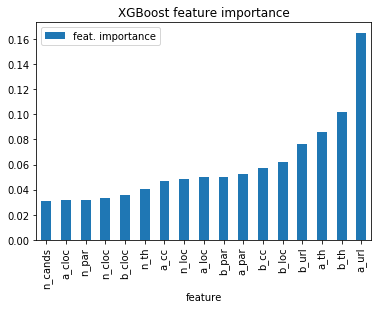

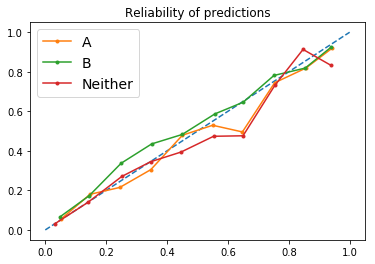

In [14]:
# Run again with optimized params

colsample_bytree, gamma, max_delta_step, max_depth, min_child_weight, n_estimators, subsample = [v for i, v in sorted(optimizer.max['params'].items())]
max_depth= int(round(max_depth))

clf = XGBClassifier(random_state=random_state, max_depth=int(max_depth), n_estimators=int(n_estimators), gamma=gamma, min_child_weight=min_child_weight,
                    max_delta_step=max_delta_step, subsample=subsample, colsample_bytree=colsample_bytree)
clf.fit(X_train_valid.values, y_train_valid)
y_pred = clf.predict(X_test.values)
y_probs = clf.predict_proba(X_test.values)
print('Accuracy:', accuracy_score(y_test, y_pred),
      '\nRecall:', recall_score(y_test, y_pred, average=None),
      '\nPrecision:', precision_score(y_test, y_pred, average=None),
      '\nF1:', f1_score(y_test, y_pred, average=None),
      '\nLog-loss:', log_loss(y_test, y_probs))

y_test_prime = np.array([(y_test == 0), (y_test == 1), (y_test == 2)]).transpose().astype(int)

print(pd.DataFrame({'a_pred': y_probs[:,0], 'b_pred': y_probs[:,1], 'n_pred': y_probs[:,2],
                    'a': y_test_prime[:,0], 'b': y_test_prime[:,1], 'n': y_test_prime[:,2]}).head())

fscores = pd.DataFrame({'feature': feature_columns, 'feat. importance': clf.feature_importances_})
fscores.sort_values(by='feat. importance').plot.bar(x='feature')
plt.title('XGBoost feature importance')
plt.show()

plt.title('Reliability of predictions')
plt.plot([0, 1], [0, 1], linestyle='--')
fop, mpv = calibration_curve(y_test_prime[:,0], y_probs[:,0], n_bins=10)
plt.plot(mpv, fop, marker='.', label='A')
fop, mpv = calibration_curve(y_test_prime[:,1], y_probs[:,1], n_bins=10)
plt.plot(mpv, fop, marker='.', label='B')
fop, mpv = calibration_curve(y_test_prime[:,2], y_probs[:,2], n_bins=10)
plt.plot(mpv, fop, marker='.', label='Neither')
plt.legend(loc='upper left', prop={'size': 14})
plt.show()

In [35]:
submission = pd.DataFrame([annotated_data.iloc[:2000,].id, y_probs[:,0], y_probs[:,1], y_probs[:,2]], index=['ID', 'A', 'B', 'NEITHER']).transpose()
submission.to_csv('submission.csv', index=False)

,ID,A,B,NEITHER
0,development-1,0.471622,0.135292,0.393086
1,development-2,0.898697,0.0774193,0.0238836
2,development-3,0.069709,0.911236,0.0190554
3,development-4,0.372942,0.456734,0.170324
4,development-5,0.16548,0.627461,0.207059
5,development-6,0.933548,0.0572208,0.00923146
6,development-7,0.47184,0.0720052,0.456155
7,development-8,0.160083,0.820852,0.0190658
8,development-9,0.0745758,0.902773,0.0226516
9,development-10,0.589394,0.386089,0.0245173
